In [4]:
from matplotlib import pyplot as plt
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
from scipy.linalg import expm
from jax import jit, grad, value_and_grad, vmap
from jax.ops import index_update, index
#from time import time
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info.operators.base_operator import BaseOperator
from qiskit.providers.aer.pulse_new.de.DE_Problems import SchrodingerProblem
from qiskit.providers.aer.pulse_new.de.DE_Solvers import BMDE_Solver
from qiskit.providers.aer.pulse_new.de.solve import solve
from qiskit.providers.aer.pulse_new.de.DE_Options import DE_Options
from qiskit.providers.aer.pulse_new.models.signals import VectorSignal, Constant, Signal, PiecewiseConstant
from qiskit.providers.aer.pulse_new.models.transfer_functions import Convolution
from qiskit.providers.aer.pulse_new.models.operator_models import OperatorModel
from qiskit.providers.aer.pulse_new.models.quantum_models import HamiltonianModel
from qiskit.providers.aer.pulse_new.models.frame import Frame
from qiskit.providers.aer.pulse_new.optimize.optimize import find_pulse_bfgs_parallel, find_pulse_bfgs
from qiskit.providers.aer.pulse_new.optimize.opt_utils import diffeo

def gaussian(amp, sig, t0, t):
    return amp * jnp.exp( -(t - t0)**2 / (2 * sig**2) )

X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')

In [5]:
amp = 1. # amplitude
sig = 2. # sigma
t0 = 3.5*sig # center of Gaussian
T = 7*sig # end of signal

gaussian_envelope = lambda t: gaussian(amp, sig, t0, t)

In [6]:
#####################
# construct operators
#####################
r = 0.5
w = 1.
X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')

operators = [2 * jnp.pi * w * Z.data/2, 
             2 * jnp.pi * r * X.data/2]

###################
# construct signals
###################

# Define gaussian envelope function to have max amp 0 and 
amp = 1.
sig = 0.399128/r
t0 = 3.5*sig
T = 7*sig
gaussian_envelope = lambda t: gaussian(amp, sig, t0, t)

signals = [Constant(1.), 
           Signal(envelope=gaussian_envelope, carrier_freq=w)]

#################
# construct model
#################

hamiltonian = HamiltonianModel(operators=operators)

In [7]:
def simulation(amp, sig, t0):
    gaussian_envelope = lambda t: gaussian(amp, sig, t0, t)
    signals = [Constant(1.), 
               Signal(envelope=gaussian_envelope, carrier_freq=w)]
    ham_copy = hamiltonian.copy()
    ham_copy.signals = signals

    se_problem = SchrodingerProblem(hamiltonian=ham_copy, 
                                    y0=jnp.array([0., 1.]), 
                                    interval=[0., T])
    return solve(se_problem, options=DE_Options(atol=1e-10, rtol=1e-10))

In [8]:
jit_simulation = jit(simulation)

In [9]:
%time y = jit_simulation(amp, sig, t0).block_until_ready()
print(np.abs(y)**2)

CPU times: user 750 ms, sys: 14.7 ms, total: 765 ms
Wall time: 763 ms
[0.99723026 0.00276974]


In [10]:
%time y = jit_simulation(amp, 4*sig, t0).block_until_ready()

CPU times: user 1.41 ms, sys: 890 µs, total: 2.3 ms
Wall time: 1.05 ms


In [11]:
T

5.587791999999999

# 2. Pulse optimization

In [31]:
dim = 3
ident = jnp.eye(dim, dtype=complex)
a = jnp.diag(jnp.sqrt(jnp.arange(1, dim, dtype=complex)), 1)
adag = a.conj().transpose()
N = adag @ a

w = 5.
anharm = -0.33
r = 0.02
dt = 1.

operators = [2 * jnp.pi * w * N + jnp.pi * anharm * N @ (N - ident),
             2 * jnp.pi * r * (a + adag)]

hamiltonian = HamiltonianModel(operators=operators)

In [37]:
# simple low pass filter function for a piecewise constant signal
def lowpass(t, sig, cutoff=0.005):
    # assumes that t is in units of ns
    dt = t[1]-t[0]
    freqs = (1/dt)*jnp.fft.fftfreq(t.shape[-1])
    sig_fft = jnp.fft.fft(sig)
    filtered_sig_fft = sig_fft*(1/(1+1.0j*freqs/cutoff))
    filtered_sig = jnp.fft.ifft(filtered_sig_fft)
    return filtered_sig

# signal generator - given params, maps them to a piecewise constant signal
# bounded between [-1, 1], smoothed by the low pass filter, driven on resonance
def signal_generator(params):
    amp_params = params[0]
    phase_params = params[1]
    normed_amps = diffeo(amp_params, [-1, 1])
    normed_phases = diffeo(phase_params, [-jnp.pi, jnp.pi])
    times = jnp.arange(params.shape[-1])*dt + dt
    smoothed_samples = lowpass(times, normed_amps * jnp.exp(1j*lowpass(times, normed_phases)))
    return [Constant(1.), PiecewiseConstant(dt=dt, samples=smoothed_samples, carrier_freq=w)]

In [38]:
frame = Frame(2 * jnp.pi * w * N)

# unitary as function of params
def get_unitary(signals):
    T = signals[1]._samples.shape[-1] * dt
    ham_copy = hamiltonian.copy()
    ham_copy.signals = signals
    ham_copy.frame = frame
    ham_copy.cutoff_freq = 2*w
    se_problem = SchrodingerProblem(ham_copy, 
                                    y0=jnp.eye(3, dtype=complex), 
                                    interval=[0., T])
    y = solve(se_problem, options=DE_Options(method='jaxexpm', max_dt=dt))
    return y

In [39]:
# fidelity to X gate
def X_fidelity(U):
    ip = (jnp.array([[0., 1.], [1., 0.]], dtype=complex).conj() * U[0:2, 0:2]).sum()
    return np.real(ip * ip.conj())/4

def obj(params):
    signals = signal_generator(params)
    return (1 - X_fidelity(get_unitary(signals))) + jnp.sqrt(jnp.abs(signals[1]._samples[0]) + jnp.abs(signals[1]._samples[-1]))

In [42]:
# specifies number of time steps
ctrl_shape = (2,60)
result = find_pulse_bfgs(obj, ctrl_shape, update_rate=200)

Optimizing pulse...
Evaluation 200: obj = 0.026868065146494004, time = 3.589211940765381
Evaluation 400: obj = 0.022260039591040115, time = 0.33672499656677246
Evaluation 600: obj = 0.017441122512042256, time = 0.3388023376464844
         Current function value: 0.017439
         Iterations: 339
         Function evaluations: 626
         Gradient evaluations: 614
Total time taken: 4.585138320922852


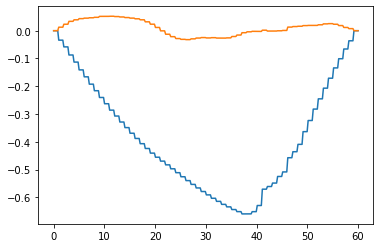

In [43]:
drive_sig = signal_generator(result.x)[1]
drive_sig.plot_envelope(0, dt*len(drive_sig._samples), ctrl_shape[-1]*5)

In [465]:
drive_sig._samples.sum()*dt

DeviceArray(0.12379951+0.45100255j, dtype=complex128)

In [51]:
U = get_unitary(result.x)

In [52]:
U @ U.conj().transpose()

DeviceArray([[ 1.00000000e+00+0.00000000e+00j,
              -1.75960679e-16+8.05007831e-16j,
               1.54539467e-16+2.88170773e-16j],
             [-1.75960679e-16-8.05007831e-16j,
               1.00000000e+00+0.00000000e+00j,
              -3.45904539e-16-1.39058881e-16j],
             [ 1.54539467e-16-2.88170773e-16j,
              -3.45904539e-16+1.39058881e-16j,
               1.00000000e+00+0.00000000e+00j]], dtype=complex128)

In [20]:
test2.plot_envelope(0, dt*ctrl_shape[-1], ctrl_shape[-1]*5)

NameError: name 'test2' is not defined

In [ ]:
test._func(2.)

In [ ]:
index_update(jnp.ones(10, dtype=float), index[-5:], jnp.zeros(5, dtype=float))

In [ ]:
jnp.flip(np.array([1, 2, 3]))

In [76]:
def lowpass(t, sig, cutoff=0.01):
    # assumes that t is in units of ns
    dt = t[1]-t[0]
    freqs = (1/dt)*jnp.fft.fftfreq(t.shape[-1])
    sig_fft = jnp.fft.fft(sig)
    filtered_sig_fft = sig_fft*(1/(1+1.0j*freqs/cutoff))
    filtered_sig = jnp.fft.ifft(filtered_sig_fft)
    return filtered_sig.real

In [156]:
dt = 0.01
N = 1 // dt
times = jnp.arange(N)*dt
sig = jnp.exp(-1j*2*jnp.pi *  1. * times)

/opt/anaconda3/envs/autodiffEnv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


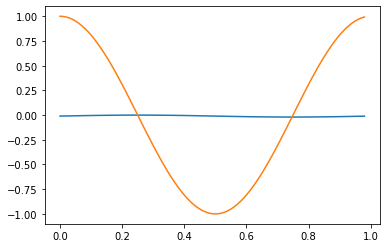

In [164]:
plt.plot(times, lowpass(times, sig, cutoff=0.01))
plt.plot(times, sig)

In [165]:
jnp.fft.ifft(1/(1+1.0j*freqs/0.01))

DeviceArray([0.01010423-8.41078049e-19j, 0.01046813-6.72862439e-18j,
             0.01037479+2.24287480e-18j, 0.01041963-1.62608423e-17j,
             0.0103765 -1.57001236e-17j, 0.01039843-2.35501854e-17j,
             0.01036861+2.24287480e-18j, 0.01038184-6.65853455e-18j,
             0.01035817+1.73822797e-17j, 0.01036683+7.28934309e-18j,
             0.01034671+1.07237451e-17j, 0.01035256+3.36431220e-18j,
             0.01033474-1.96251545e-18j, 0.01033871+8.97149919e-18j,
             0.01032249+1.21956317e-17j, 0.0103251 -1.45786862e-17j,
             0.01031006-1.12143740e-17j, 0.01031167-2.18680293e-17j,
             0.01029753-1.12143740e-18j, 0.01029835-1.40179675e-17j,
             0.01028492-1.20554520e-17j, 0.01028513+1.82233577e-17j,
             0.01027226+1.40179675e-17j, 0.01027198-1.73822797e-17j,
             0.01025957+8.97149919e-18j, 0.01025889+2.24287480e-18j,
             0.01024686+8.97149919e-18j, 0.01024584+2.41109041e-17j,
             0.01023414-1.03732959

In [117]:
freqs

DeviceArray([ 0.        ,  1.11111111,  2.22222222,  3.33333333,
              4.44444444, -4.44444444, -3.33333333, -2.22222222,
             -1.11111111], dtype=float64)

In [108]:
jnp.fft.fft(np.array([1., -1., 1., -1.]))

DeviceArray([0.+0.j, 0.+0.j, 4.+0.j, 0.+0.j], dtype=complex128)

In [141]:
help(jnp.fft.fft)

Help on function fft in module jax._src.numpy.fft:

fft(a, n=None, axis=-1, norm=None)
    Compute the one-dimensional discrete Fourier Transform.
    
    LAX-backend implementation of :func:`fft`.
    Original docstring below.
    
    This function computes the one-dimensional *n*-point discrete Fourier
    Transform (DFT) with the efficient Fast Fourier Transform (FFT)
    algorithm [CT].
    
    Parameters
    ----------
    a : array_like
        Input array, can be complex.
    n : int, optional
        Length of the transformed axis of the output.
        If `n` is smaller than the length of the input, the input is cropped.
        If it is larger, the input is padded with zeros.  If `n` is not given,
        the length of the input along the axis specified by `axis` is used.
    axis : int, optional
        Axis over which to compute the FFT.  If not given, the last axis is
        used.
    norm : {None, "ortho"}, optional
        .. versionadded:: 1.10.0
    
    Returns
  

In [44]:
ham_copy = hamiltonian.copy()
ham_copy.signals = signals
ham_copy.frame = frame
ham_copy.cutoff_freq = 2*w

In [45]:
ham_copy.evaluate(0.2)

DeviceArray([[ 0.00000000e+00+0.00000000e+00j,
               1.97854237e-04+4.84603117e-20j,
               0.00000000e+00+0.00000000e+00j],
             [ 1.97854237e-04-4.84603117e-20j,
               0.00000000e+00+0.00000000e+00j,
               2.79808146e-04-9.25544996e-19j],
             [ 0.00000000e+00+0.00000000e+00j,
               2.79808146e-04+9.25544996e-19j,
              -2.07345115e+00+0.00000000e+00j]], dtype=complex128)

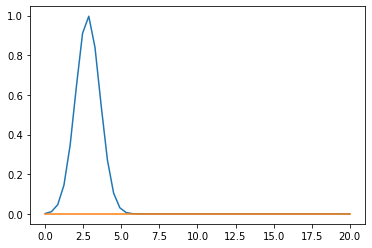

In [46]:
signals[1].plot_envelope(0, 20, 50)

In [254]:
N @(N - ident)

DeviceArray([[0.+0.j, 0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j, 2.+0.j]], dtype=complex128)

In [303]:
ham_copy.signals = [Constant(1.), PiecewiseConstant(dt=1., samples=jnp.array([1., 1.+1j, 2j]), carrier_freq=w)]

In [304]:
ham_copy.evaluate(0.5)[0,1]

DeviceArray(0.06283185+8.4099027e-34j, dtype=complex128)

In [306]:
ham_copy.evaluate(0.65)[1,2]

DeviceArray(0.01965603+0.08665636j, dtype=complex128)

In [267]:
frame.frame_operator

DeviceArray([[ 0.        +0.j,  0.        +0.j,  0.        +0.j],
             [ 0.        +0.j, 31.41592654+0.j,  0.        +0.j],
             [ 0.        +0.j,  0.        +0.j, 60.75840192+0.j]],            dtype=complex128)

In [48]:
dim = 10
ident = jnp.eye(dim, dtype=complex)
a = jnp.diag(jnp.sqrt(jnp.arange(1, dim, dtype=complex)), 1)
adag = a.conj().transpose()
N = adag @ a

w = 5.
anharm = -0.33
r = 0.02
dt = 1.

operators = [2 * jnp.pi * w * N + np.pi * anharm * N @ (N - ident),
             2 * jnp.pi * r * (a + adag)]

hamiltonian = HamiltonianModel(operators=operators)
hamiltonian.signals = [Constant(1.), PiecewiseConstant(dt=dt, samples=jnp.array([1., 1.+1j, 2j]), carrier_freq=w)]

hamiltonian.frame = 2 * jnp.pi * w * N
hamiltonian.cutoff_freq = 2*w

In [49]:
def plot_qubit_hamiltonian_components(hamiltonian, t0, tf, N=200):
    t_vals = np.linspace(t0, tf, N)
    model_vals = np.array([hamiltonian.evaluate(t) for t in t_vals])
    x_coeff = model_vals[:, 0, 1].real
    y_coeff = -model_vals[:, 0, 1].imag
    z_coeff = model_vals[:, 1, 2].real
    w_coeff = -model_vals[:, 1, 2].imag
    plt.plot(t_vals, x_coeff, label='X coefficient')
    plt.plot(t_vals, y_coeff, label='Y coefficient')
    plt.plot(t_vals, z_coeff, label='Z coefficient')
    plt.plot(t_vals, w_coeff, label='W coefficient')
    plt.legend()

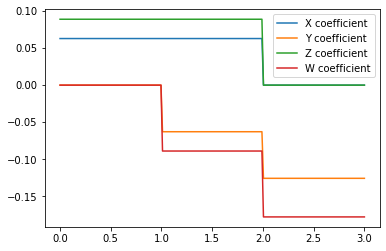

In [50]:
plot_qubit_hamiltonian_components(hamiltonian, 0, 3*dt)

In [51]:
print(quad(lambda t: hamiltonian.evaluate(t)[1,2].real, 0, dt))
print(quad(lambda t: hamiltonian.evaluate(t)[1,2].imag, 0, dt))

NameError: name 'quad' is not defined

In [426]:
hamiltonian.evaluate(0.65*dt)[0,1]

DeviceArray(0.06283185-1.85565211e-19j, dtype=complex128)

In [400]:
from scipy.integrate import quad

In [401]:
help(quad)

Help on function quad in module scipy.integrate.quadpack:

quad(func, a, b, args=(), full_output=0, epsabs=1.49e-08, epsrel=1.49e-08, limit=50, points=None, weight=None, wvar=None, wopts=None, maxp1=50, limlst=50)
    Compute a definite integral.
    
    Integrate func from `a` to `b` (possibly infinite interval) using a
    technique from the Fortran library QUADPACK.
    
    Parameters
    ----------
    func : {function, scipy.LowLevelCallable}
        A Python function or method to integrate. If `func` takes many
        arguments, it is integrated along the axis corresponding to the
        first argument.
    
        If the user desires improved integration performance, then `f` may
        be a `scipy.LowLevelCallable` with one of the signatures::
    
            double func(double x)
            double func(double x, void *user_data)
            double func(int n, double *xx)
            double func(int n, double *xx, void *user_data)
    
        The ``user_data`` is the d